In [1]:
import warnings
warnings.filterwarnings("ignore")

from fastai.vision import *
from fastai.metrics import error_rate
import torch

torch.cuda.empty_cache()

In [2]:
#masukkin image dataset nya disini, tapi per folder harus ada labelnya
#Reference Implementation fastai --->>> https://gilberttanner.com/blog/fastai-image-classification

tfms = get_transforms(max_lighting=0.4, max_zoom=1.2, max_warp=0.2, max_rotate=20, xtra_tfms=[flip_lr()])
defaults.device = torch.device("cuda")
data = ImageDataBunch.from_folder(Path('./dataset'),
                                  train = 'train/',
                                  valid_pct = 0.1,
                                  resize_method=ResizeMethod.SQUISH, 
                                  ds_tfms = tfms,
                                  size = 299,
                                  bs = 32,
                                  num_workers = 50
                                  ).normalize(imagenet_stats)

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
len(data.classes), data.c

In [ ]:
import pretrainedmodels
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()
    
    
# model nyta buat cnn_learner
def senet(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.senet154(pretrained=pretrained)
    return nn.Sequential(*list(model.children()))

def identity(x): return x

def pnasnet5large(pretrained=False):    
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.pnasnet5large(pretrained=pretrained, num_classes=1000) 
    model.logits = identity
    return nn.Sequential(model)

In [4]:
from efficientnet_pytorch import EfficientNet

def get_model(pretrained=True, **kwargs): 
    model = EfficientNet.from_pretrained('efficientnet-b3')
    model._fc = nn.Linear(model._fc.in_features, data.c) # check the top most layer
    return model 

learn = Learner(data, get_model(),
               metrics = [accuracy], 
               wd=.1, 
               path='.').mixup().to_fp16() # because different clf layer, we use Learner.


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3


In [ ]:
# model fastai --->>> https://docs.fast.ai/vision.models.html
# best practice: start small, 
# baru ganti model IF tuning hyperparameter udah gak improved.
learn = cnn_learner(data, 
                    senet, 
                    pretrained=True, 
                    cut=-2, 
                    metrics = [accuracy]
                   )
learn.loss_fn = FocalLoss()


In [ ]:
# model fastai --->>> https://docs.fast.ai/vision.models.html
# best practice: start small, 
# baru ganti model IF tuning hyperparameter udah gak improved.
learn = cnn_learner(data, 
                    pnasnet5large, 
                    metrics = accuracy, 
                    cut=None
                   )
learn.loss_fn = FocalLoss()


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03
Min loss divided by 10: 7.59E-04


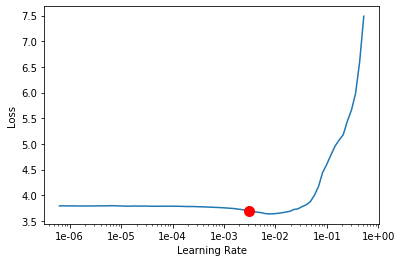

In [5]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [ ]:
learn.fit_one_cycle(4, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.save('b3');
learn.unfreeze();
learn = learn.clip_grad();

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.load('b3');
learn.unfreeze();
learn = learn.clip_grad();
min_grad_lr = learn.recorder.min_grad_lr

In [ ]:

learn.fit_one_cycle(12, min_grad_lr)

In [ ]:
learn.save('b3')
learn.export('b3')

# using ResNeXt-101-32x8d

In [ ]:
import pretrainedmodels
from torch import nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()
    
# model nyta buat cnn_learner
def resnext101_32x8d(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = bn.resnext101_32x8d(pretrained=pretrained)
    return nn.Sequential(*list(model.children()))

In [ ]:
# model fastai --->>> https://docs.fast.ai/vision.models.html
# best practice: start small, 
# baru ganti model IF tuning hyperparameter udah gak improved.
learn = cnn_learner(data, 
                    resnext50_32x4d, 
                    pretrained=True, 
                    cut=-2, 
                    metrics = [accuracy]
                   )
learn.loss_fn = FocalLoss()


In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(32, max_lr=slice(2e-2), wd=1e-5)

In [ ]:
learn.save('resnext101_32x8d');
learn.unfreeze();
learn = learn.clip_grad();

In [ ]:
def make_submission(learn, filename):
  log_preds, test_labels = learn.get_preds(ds_type=DatasetType.Test)
  preds = np.argmax(log_preds, 1)
  a = np.array(preds)
  submission = pd.DataFrame({'image_name': os.listdir('data/test'), 'label': a})
  submission.to_csv(path/filename, index=False)